# Attention Is All You Need


_This notebook demonstrates the implementation of Transformers architecture proposed by [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762) for neural machine translation (NMT)._


> _Sequence-to-sequence models are deep learning models that have achieved a lot of success in tasks like machine translation, text summarization, and image captioning. Google Translate started [using](https://blog.google/products/translate/found-translation-more-accurate-fluent-sentences-google-translate/) such a model in production in late 2016. These models are explained in the two pioneering papers ([Sutskever et al., 2014](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf), [Cho et al., 2014](http://emnlp2014.org/papers/pdf/EMNLP2014179.pdf)). (Excerpt from a [blog post](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) by Jay Alammar)_

Sequence-to-sequence (aka seq2seq) model is an end-to-end deep learning model which transforms one sequence to another. It consists of two recurrent neural networks:
- encoder, which encodes an input sequence of variable size into a context vector of fixed size
- decoder, which unfolds the context vector into a new sequence (output).


![seq2seq model](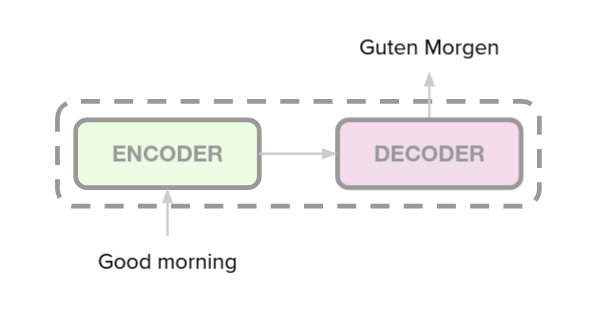 "Seq2Seq Model")


Seq2Seq NMT model can be thought of autoregressive language model where the decoder finds the target sequence that is the most probable conditioned on the input sequence. Mathematically, it can be formulated as follows:

$$
P(y|x) = P(y_1|x) P(y_2|y_1,x) \dots P(y_T|y_1, \dots, y_{T-1}, x)
$$

where $x$ is the input sequence and $y$ is the output sequence.


Attention mechanism have overcomed the drawback of vanilla seq2seq models by providing us a way to see different parts of encoder outputs during the decoding stage, which allows us to preserve the context. The attention mechanim between encoder and decoder resulted in performance improvements for machine translation task.

Transformer are a class of deep learning models which does not use any recurrence. Instead they use self-attention mechanism for representations to find global dependencies between input and target. Transformers have become the de facto standard in NLP and have achieved state-of-the-art performance for various tasks. The Transformer is behind all the popular language models such as BERT, GPT, etc.


We will build a Transformer model for English to German translation using PyTorch.


In [7]:
%%capture
# download the spacy language models for english and german
!python -m spacy download en --quiet
!python -m spacy download de --quiet

In [8]:
%%capture
!pip install torchtext --upgrade

In [9]:
!pip uninstall torchtext
!pip install torchtext==0.17.2



Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/torchtext-0.18.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/torchtext/*
Proceed (Y/n)? n
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

## Imports


In [1]:
!pip install numpy<2.0
import math
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy
import torchtext
from torchtext.data.metrics import bleu_score
from torchtext.datasets import Multi30k
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')


print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)

/bin/bash: line 1: 2.0: No such file or directory



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

PyTorch version: 2.2.2+cu121
NumPy version: 2.0.2


In [2]:
# plot style configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

In [3]:
# for reproducibility
# refer https://pytorch.org/docs/stable/notes/randomness.html
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing and Loading


In [5]:
!pip install transformers==4.35.2 torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 100.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.0
    Uninstalling transformers-4.50.0:
      Successfully uninstalled transformers-4.50.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.35.2 which is incompatible.


In [6]:
# spacy_en = spacy.load('en')
# spacy_de = spacy.load('de')

# def tokenize_en(text):
#     """ Translates english text sequence into a list of tokens.
#     """
#     return [token.text for token in spacy_en.tokenizer(text)]

# def tokenize_de(text):
#     """ Translates german text sequence into a list of tokens.
#     """
#     return [token.text for token in spacy_de.tokenizer(text)]

# PAD_TOKEN = '<pad>'
# SOS_TOKEN = '<s>'
# EOS_TOKEN = '</s>'
# UNK_TOKEN = '<unk>'

# # english text field
# en_text = Field(
#     tokenize=tokenize_en, lower=True, include_lengths=True, batch_first=True,
#     pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN, unk_token=UNK_TOKEN,
# )

# # german text field
# de_text = Field(
#     tokenize=tokenize_de, lower=True, include_lengths=True, batch_first=True,
#     pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN, unk_token=UNK_TOKEN,
# )
from transformers import AutoTokenizer
# from transformers import BertTokenizerFast
# from transformers import BertTokenizerFast

# Load a BERT tokenizer trained for SMILES (e.g., ChemBERTa)
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1",
                                              do_lower_case=False,
                                              use_fast=True)


# Example SMILES string
smiles_example = "CC(C)C(=O)O"

# Tokenize the SMILES string
tokens = tokenizer.tokenize(smiles_example)
print("Tokenized SMILES:", tokens)

# Encode the SMILES string
encoding = tokenizer(smiles_example, return_tensors='pt')
print("\nInput IDs:", encoding['input_ids'][0])
print("Attention Mask:", encoding['attention_mask'][0])

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Tokenized SMILES: ['CC', '(', 'C', ')', 'C', '(=', 'O', ')', 'O']

Input IDs: tensor([  0, 262,  12,  39,  13,  39, 263,  51,  13,  51,   2])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [7]:
# data_fields = [('src', smiles_field), ('trgt', smiles_field)]

# train_data, valid_data, test_data = TabularDataset.splits(
#     path="data/", train="smiles.csv", validation="valid.csv", test="test.csv",
#     format="csv", fields=data_fields
# )
from transformers import AutoTokenizer
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Load ChemBERTa Tokenizer
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", do_lower_case=False, use_fast=True)

# Custom Dataset with Tokenized SMILES
class SMILESDataset(Dataset):
    def __init__(self, csv_path, src_column, tgt_column, tokenizer, max_length=100):
        # Read the CSV file
        self.data = pd.read_csv(csv_path)

        # Select specific columns
        self.src = self.data[src_column].tolist()
        self.tgt = self.data[tgt_column].tolist()
        self.tokenizer = tokenizer  # Store tokenizer
        self.max_length = max_length  # Define max token length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Tokenize and encode using BERT tokenizer
        src_encoding = self.tokenizer(
            self.src[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        tgt_encoding = self.tokenizer(
            self.tgt[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            'src': src_encoding['input_ids'].squeeze(0),  # Convert to tensor
            'src_mask': src_encoding['attention_mask'].squeeze(0),
            'tgt': tgt_encoding['input_ids'].squeeze(0),
            'tgt_mask': tgt_encoding['attention_mask'].squeeze(0)
        }

# Create DataLoader
def create_dataloader(csv_path, src_column, tgt_column, tokenizer, batch_size=32, shuffle=True, max_length=100):
    dataset = SMILESDataset(csv_path, src_column, tgt_column, tokenizer, max_length)

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle
    )



In [9]:

from torch.utils.data import Dataset, DataLoader, random_split
csv_path = "/content/cleaned_output.csv"  # Ensure this file exists
src_column = "src"
tgt_column = "tgt"

# Create full dataset
dataset = SMILESDataset(csv_path, src_column, tgt_column, tokenizer)

# Define Training & Validation Split
train_size = int(0.8 * len(dataset))  # 80% Training Data
valid_size = len(dataset) - train_size  # 20% Validation Data

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Print dataset sizes
BATCH_SIZE = 32
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(valid_dataset)}")

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, BATCH_SIZE, shuffle=False)

# Print first batch
for batch in train_dataloader:
    print("First batch - Tokenized Source SMILES:", batch["src"][:2])
    print("First batch - Tokenized Target SMILES:", batch["tgt"][:2])
    break

Training examples: 4440
Validation examples: 1111
First batch - Tokenized Source SMILES: tensor([[  0,  50,  67,  24,  14,  39, 263,  51,  13,  39,  12, 262, 263,  51,
          13,  51,  13, 268, 263,  51,  13,  39,  12, 267,  21, 269,  21,  13,
          50,  12,  39,  13,  39, 263,  51,  13,  39,  12, 268, 263,  51,  13,
          39,  12,  14,  13, 370, 263,  50,  13,  50,  13,  39,  12,  39,  13,
          39,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1],
        [  0,  50,  67,  25,  14,  39,  12, 370, 263,  50,  13,  50,  13, 268,
         263,  51,  13,  39,  12, 262,  12,  39,  13,  39,  13, 268, 263,  51,
          13, 407,  12, 268, 263,  51,  13,  39,  12,  14,  13, 262, 263,  51,
          13,  51,  13,  39, 263,  51,  13,  51,   2,   1,   1,   1,   1,   1,
           1,   1,   1

# New section

In [ ]:
# # build the english and german vocabulary
# en_text.build_vocab(train_data.src, max_size=10000, min_freq=2)
# de_text.build_vocab(train_data.trg, max_size=10000, min_freq=2)

In [10]:
import pandas as pd
from collections import Counter

# Load the cleaned SMILES dataset
df = pd.read_csv("/content/cleaned_output.csv")

# Combine all SMILES into one long string
smiles_list = df["src"].tolist() + df["tgt"].tolist()
all_smiles = "".join(smiles_list)

# Count unique characters
char_vocab = Counter(all_smiles)

# Create a dictionary mapping each unique character to an index
char2idx = {char: idx+1 for idx, char in enumerate(char_vocab.keys())}  # Start indexing from 1

# Add special tokens
char2idx["<pad>"] = 0  # Padding token
char2idx["<s>"] = len(char2idx)  # Start token
char2idx["</s>"] = len(char2idx)  # End token
char2idx["<unk>"] = len(char2idx)  # Unknown token

# Print vocabulary
print("Vocabulary size:", len(char2idx))
print("Character-to-Index Mapping:", char2idx)

Vocabulary size: 38
Character-to-Index Mapping: {'N': 1, '_': 2, '5': 3, '*': 4, 'C': 5, '(': 6, '=': 7, 'O': 8, ')': 9, 'c': 10, '1': 11, '[': 12, 'n': 13, 'H': 14, ']': 15, '2': 16, '4': 17, '7': 18, '3': 19, 'P': 20, 'F': 21, '6': 22, '8': 23, 'l': 24, '+': 25, '-': 26, '#': 27, 'o': 28, 'S': 29, 'I': 30, '9': 31, 's': 32, 'B': 33, 'r': 34, '<pad>': 0, '<s>': 35, '</s>': 36, '<unk>': 37}


In [ ]:
# print(f'# of training examples: {len(train_data.examples)}')
# print(f'# of validation examples: {len(valid_data.examples)}')
# print(f'# of testing examples: {len(test_data.examples)}')

# print(train_data[0].__dict__.keys())
# print(train_data[0].__dict__.values())


In [ ]:
# BATCH_SIZE = 64

# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, valid_data, test_data),
#     batch_size=BATCH_SIZE,
#     sort_within_batch=True,
#     sort_key=lambda x: len(x.src),
#     device=device
# )

In [11]:
# sanity check to see if data loader is working
# x = next(iter(train_iterator))

# print({'source': x.src[0].shape, 'source_lengths': x.src[1].shape})
# print({'target': x.trg[0].shape, 'target_lengths': x.trg[1].shape})
x = next(iter(train_dataloader))

# Print the shapes of tokenized SMILES sequences
print({'source': x['src'].shape, 'source_mask': x['src_mask'].shape})
print({'target': x['tgt'].shape, 'target_mask': x['tgt_mask'].shape})

{'source': torch.Size([32, 100]), 'source_mask': torch.Size([32, 100])}
{'target': torch.Size([32, 100]), 'target_mask': torch.Size([32, 100])}


## Model Architecture


![transformer_model](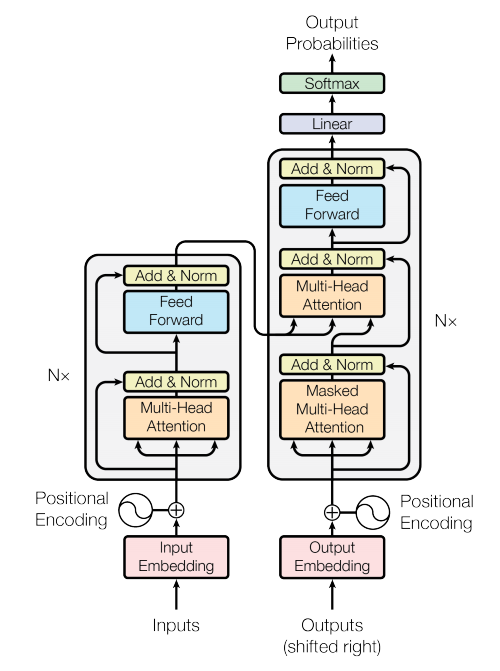 "Transformer Model")

(source: https://arxiv.org/pdf/1706.03762.pdf)


### Scaled Dot-Product Attention


![scaled_dot_product_attention](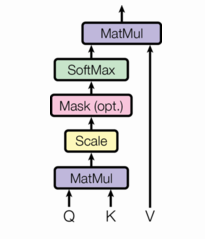 "Scaled Dot-Product Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)


> _An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key. (Excerpt from [Attention is All You Need paper](https://arxiv.org/pdf/1706.03762.pdf))_

The Transformer uses scaled dot-production attention as a self-attention block to compute the representations by taking the dot product of the query matrix $Q$ and the key matrix $K$ scaled by square root of head dimension ($\sqrt{d_k}$) followed by applying softmax and multiplying the values matrix $V$.

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V
$$

The scaled dot-product attention is similar to standard dot-product (multiplicative) attention except that we use a scaling factor $\sqrt{d_k}$ in order to avoid extremely small gradients.

Scaled Dot-Product Attention returns the following:
- `output`: weighted sum of the values (self-attention representations) w.r.t alignment scores
- `attn_probs`: alignment scores indicating how well values around position $i$ match with values around position $j$


In [12]:
import torch.nn as nn
import torch.nn.functional as F
class ScaledDotProductAttention(nn.Module):
    """ Computes scaled dot product attention
    """

    def __init__(self, scale, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = scale
        self.dropout_rate = dropout_rate

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, n_heads, query_len, head_dim)
            key: (batch_size, n_heads, key_len, head_dim)
            value: (batch_size, n_heads, value_len, head_dim)
            mask: (batch_size, 1, 1, source_seq_len) for source mask
                  (batch_size, 1, target_seq_len, target_seq_len) for target mask
        """
        # calculate alignment scores
        scores = torch.matmul(query, key.transpose(-2, -1))  # (batch_size, n_heads, query_len, value_len)
        scores = scores / self.scale  # (batch_size, num_heads, query_len, value_len)

        # mask out invalid positions
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))  # (batch_size, n_heads, query_len, value_len)

        # calculate the attention weights (prob) from alignment scores
        attn_probs = F.softmax(scores, dim=-1)  # (batch_size, n_heads, query_len, value_len)

        # calculate context vector
        output = torch.matmul(self.dropout(attn_probs), value)  # (batch_size, n_heads, query_len, head_dim)

        # output: (batch_size, n_heads, query_len, head_dim)
        # attn_probs: (batch_size, n_heads, query_len, value_len)
        return output, attn_probs

### Multi-Head Attention Module


![multi_head_attention](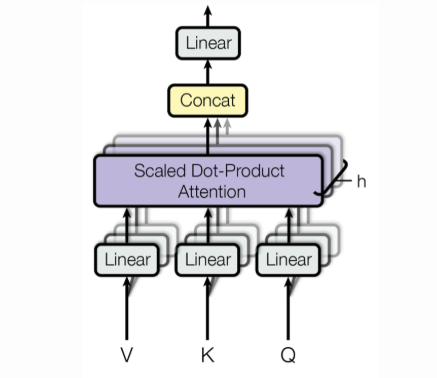 "Multi-Head Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)


Instead of using single self-attention layer, the authors introduced multi-head attention mechanism which simply performs multiple scaled dot-product attention computations in parallel. The authors split queries, keys and values with $d_{model}$ dimension into $h$ heads and then re-combine scaled dot-product computation over each head into a single vector with $d_model$ dimension.

> _Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. (Excerpt from [Attention is All You Need paper](https://arxiv.org/pdf/1706.03762.pdf))_

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O \\
\text{where}\ \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\
W_i^Q \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^K \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^V \in \mathbb{R}^{\mathrm{d_{model}\times d_v}}, W_i^O \in \mathbb{R}^{\mathrm{hd_v\times d_{model}}}
$$

First, the inputs: query matrix $Q$, key matrix $K$ and value matrix $V$ are linearly projected using $W^Q$, $W^K$ and $W^V$. The projected query $QW^Q$, key $KW^K$ and value $VW^V$ are split into $h$ heads. Scaled dot-product attention is computed for each head $i$. The independent attention head computed are then concatenated and linearly projected using $W^O$.

Multi-Head Attention returns the following:
- `x`: context vector concatenated over all the attention heads
- `attn`: alignment scores (attention weights) over all the attention heads


In [13]:
class MultiHeadAttention(nn.Module):
    """ Implements Multi-Head Self-Attention proposed by Vaswani et al., 2017.
        refer https://arxiv.org/abs/1706.03762
    """

    def __init__(self, d_model, n_heads, dropout_rate=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "`d_model` should be a multiple of `n_heads`"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = self.d_v = d_model // n_heads  # head_dim
        self.dropout_rate = dropout_rate

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(np.sqrt(self.d_k), dropout_rate)


    def split_heads(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_k)

        # x: (batch_size, n_heads, seq_len, head_dim)
        return x


    def group_heads(self, x):
        """ x: (batch_size, n_heads, seq_len, head_dim)
        """
        batch_size = x.size(0)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)

        # x: (batch_size, seq_len, d_model)
        return x


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, query_len, d_model)
            key: (batch_size, key_len, d_model)
            value: (batch_size, value_len, d_model)
            mask: (batch_size, 1, source_seq_len) for source mask
                  (batch_size, target_seq_len, target_seq_len) for target mask
        """
        # apply linear projections to query, key and value
        Q = self.split_heads(self.W_q(query))  # (batch_size, n_heads, query_len, head_dim)
        K = self.split_heads(self.W_k(key))  # (batch_size, n_heads, key_len, head_dim)
        V = self.split_heads(self.W_v(value))  # (batch_size, n_heads, value_len, head_dim)

        if mask is not None:
            # apply same mask for all the heads
            mask = mask.unsqueeze(1)

            # mask: (batch_size, 1, 1, source_seq_len) for source mask
            #       (batch_size, 1, target_seq_len, target_seq_len) for target mask

        # calculate attention weights and context vector for each of the heads
        x, attn = self.attention(Q, K, V, mask)

        # x: (batch_size, n_heads, query_len, head_dim)
        # attn: (batch_size, n_heads, query_len, value_len)

        # concatenate context vector of all the heads
        x = self.group_heads(x)  # (batch_size, query_len, d_model)

        # apply linear projection to concatenated context vector
        x = self.W_o(x)  # (batch_size, query_len, d_model)

        # x: (batch_size, query_len, d_model)
        # attn: (batch_size, n_heads, query_len, value_len)
        return x, attn

### Position-wise Feed-Forward Network Module


This is the another block in the encoder as well as decoder layer which transforms from $d_{model}$ to $d_{ff}$ and then again to $d_{model}$. The same linear transformation is applied across different positions. This can also be viewed as two convolutions with filter size 1.

$$
FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
$$

Position-wise Feed-Forward Network returns the following:
- `x`: non-linearity transformed vector of dimension same as input


In [14]:
class PositionwiseFeedForward(nn.Module):
    """ Implements a two layer feed-forward network.
    """

    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout_rate = dropout_rate

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = self.dropout(F.relu(self.w_1(x)))  # (batch_size, seq_len, d_ff)
        x = self.w_2(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

### Positional Encoding Module


Since the transformer contains no recurrence and no convolutions, we need some way to inject information about relative or absolute position to assign order to tokens in the sequence. Sinusoidal positional encodings are used with different frequencies to unique represent the order and the position of the token in sequence.

$$
\begin{aligned}
\text{PE}_{(pos, 2i)} &= \text{sin}(\frac{pos}{10000^{2i/d_{model}}}) \\
\text{PE}_{(pos, 2i + 1)} &= \text{cos}(\frac{pos}{10000^{2i/d_{model}}})
\end{aligned}
$$

where $pos$ is the position and $i$ is the dimension.

> _We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. (Excerpt from [Attention is All You Need paper](https://arxiv.org/pdf/1706.03762.pdf))_

Positional Encoding Module returns the following:
- `x`: word embedding of the token in the sequence with inherent position information


In [15]:
class PositionalEncoding(nn.Module):
    """ Implements the sinusoidal positional encoding.
    """

    def __init__(self, d_model, dropout_rate=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.dropout = nn.Dropout(dropout_rate)

        # compute positional encodings
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # (d_model,)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:x.size(0), :]  # (batch_size, seq_len, d_model)
        x = self.dropout(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

### Encoder Module


The encoder consists of a stack of $N = 6$ identical layers, each containing two sub-layers, a multi-head self-attention layer, and a position-wise fully connected feed-forward network. Each sub-layer has a residual connection and layer normalization.

Encoder returns the following:
- `x`: encoded sequence representation using self-attention


In [16]:
class EncoderLayer(nn.Module):
    """ Encoder is made up of a self-attention layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len, d_model)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x, mask)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

In [17]:
class Encoder(nn.Module):
    """ Encoder block is a stack of N identical encoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, source_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, source_seq_len, d_model)

        for layer in self.layers:
            x = layer(x, mask)  # (batch_size, source_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

### Decoder Module


The decoder is quite similar to the encoder, except that the decoder contains two multi-head self-attention layers instead of a single layer in a stack of $N = 6$ identical layers. The first multi-head self-attention layer attends to decoder outputs generated so far and is masked in order to prevent positions from attending to future positions, whereas the second multi-head self-attention layer attends over the encoder stack output.

Decoder returns the following:
- `x`: output sequence representation using self-attention
- `attn`: alignment scores (attention weights) between input sequence and output sequence


In [18]:
class DecoderLayer(nn.Module):
    """ Decoder is made up of a self-attention layer, a encoder-decoder attention
        layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.enc_attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model)
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x, tgt_mask)  # (batch_size, target_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # apply encoder-decoder attention
        # memory is the output from encoder block (encoder states)
        x1, attn = self.enc_attn_layer(x, memory, memory, src_mask)

        # x1: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, target_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

In [19]:
class Decoder(nn.Module):
    """ Decoder block is a stack of N identical decoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model)
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        for layer in self.layers:
            x, attn = layer(x, memory, src_mask, tgt_mask)  # (batch_size, target_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

### Transformer


The input and output sequences are embedded into a $d_{model}$ dimensional space, which is the usual step before feeding the sequence into the neural network. Positional encoding is also applied to the embedded sequence, which gives a sense of order in the sequence. Encoder encodes the input sequence and generates encoded representation using self-attention mechanism. The decoder uses this representation along with the sequence generated so far to compute the output sequence.

The Transformer returns the following:
- `output`: output sequence generated
- `attn`: alignment scores (attention weights) between input sequence and output sequence


In [20]:
class Transformer(nn.Module):
    """ Transformer wrapper for encoder and decoder.
    """

    def __init__(self, encoder, decoder, generator, pad_idx):
        super(Transformer, self).__init__()
        self.pad_idx = pad_idx

        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator


    def get_pad_mask(self, x, pad_idx):
        """ x: (batch_size, seq_len)
        """
        x = (x != pad_idx).unsqueeze(-2)  # (batch_size, 1, seq_len)

        # x: (batch_size, 1, seq_len)
        return x


    def get_subsequent_mask(self, x):
        """ x: (batch_size, seq_len)
        """
        seq_len = x.size(1)
        subsequent_mask = torch.triu(torch.ones((1, seq_len, seq_len), device=x.device), diagonal=1) == 0# (batch_size, seq_len, seq_len)


        # subsequent_mask: (batch_size, seq_len, seq_len)
        return subsequent_mask


    def forward(self, src, tgt):
        """ src: (batch_size, source_seq_len)
            tgt: (batch_size, target_seq_len)
        """
        # create masks for source and target
        src_mask = self.get_pad_mask(src, self.pad_idx)
        tgt_mask = self.get_pad_mask(tgt, self.pad_idx) & self.get_subsequent_mask(tgt)

        # src_mask: (batch_size, 1, seq_len)
        # tgt_mask: (batch_size, seq_len, seq_len)

        # encode the source sequence
        enc_output = self.encoder(src, src_mask)  # (batch_size, source_seq_len, d_model)

        # decode based on source sequence and target sequence generated so far
        dec_output, attn = self.decoder(tgt, enc_output, src_mask, tgt_mask)

        # dec_output: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)

        # apply linear projection to obtain the output distribution
        output = self.generator(dec_output)  # (batch_size, target_seq_len, vocab_size)

        # output: (batch_size, target_seq_len, vocab_size)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return output, attn

In [21]:
class Generator(nn.Module):
    """ Linear projection layer for generating output distribution.
    """

    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)


    def forward(self, x):
        """ x: (batch_size, target_seq_len, d_model)
        """
        # apply linear projection followed by softmax to obtain output distribution
        x = self.proj(x)  # (batch_size, target_seq_len, vocab_size)
        output = F.log_softmax(x, dim=-1)  # (batch_size, target_seq_len)

        # output: (batch_size, target_seq_len)
        return output

## Helper Utilities


In [22]:
def model_summary(model):
    print(model)
    print(f'# of trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
    print(f'# of non-trainable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}')

In [23]:
def convert_ids_to_text(ids, vocab, eos_idx, unk_idx):
    """ Converts token ids to text.
    """
    if ids.dim() == 1:
        output_tokens = []
        for token_id in ids:
            if token_id == eos_idx:
                break
            else:
                output_tokens.append(vocab.itos[token_id])
        return output_tokens

    elif ids.dim() == 2:
        return [convert_ids_to_text(ids[i, :], vocab, eos_idx, unk_idx) for i in range(ids.size(0))]

    raise RuntimeError(f'ids has {ids.size()} dimensions, expected 2 dimensions')

In [24]:
class NoamOptim(object):
    """ Optimizer wrapper for learning rate scheduling.
    """

    def __init__(self, optimizer, d_model, factor, n_warmup_steps):
        self.optimizer = optimizer
        self.d_model = d_model
        self.factor = factor
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def zero_grad(self):
        self.optimizer.zero_grad()


    def step(self):
        self.n_steps += 1
        lr = self.get_lr()
        for p in self.optimizer.param_groups:
            p['lr'] = lr
        self.optimizer.step()


    def get_lr(self):
        return self.factor * (
            self.d_model ** (-0.5)
            * min(self.n_steps ** (-0.5), self.n_steps * self.n_warmup_steps ** (-1.5))
        )

## Training


In [25]:
def train_fn(model, iterator, optimizer, critertion, clip=1.0):
    model.train()
    total_loss = 0
    steps = 0

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    # for idx, batch in enumerate(tk0):
    #     source, source_lengths = batch.src
    #     target, target_lengths = batch.trg
    for batch in tk0:
        src = batch['src'].to(device)  # Input sequence (source SMILES)
        src_mask = batch['src_mask'].to(device)  # Source attention mask
        tgt = batch['tgt'].to(device)  # Target sequence (macrocyclic SMILES)
        tgt_mask = batch['tgt_mask'].to(device)  # Target attention mask


        # source: (batch_size, source_seq_len), source_lengths: (batch_size)
        # target: (batch_size, target_seq_len), target_lengths: (batch_size)

        # forward pass
        optimizer.zero_grad()
        output, _ = model(src, tgt[:, :-1])   # (batch_size, target_seq_len - 1, vocab_size)

        # calculate the loss
        loss = criterion(
            output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
            tgt[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
        )
        total_loss += loss.item()
        steps += 1

        output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)

        # backward pass
        loss.backward()

        # clip gradients to avoid exploding gradients issue
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update model parameters
        optimizer.step()

        tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))

    return output, perplexity

In [26]:
def simple_smiles_eval(model, dataloader, criterion, device, tokenizer):
    """
    Simple evaluation function for SMILES generation without requiring RDKit.
    Focuses on string-based metrics.
    """
    model.eval()
    total_loss = 0.0

    # Lists to store results
    pred_smiles_list = []
    target_smiles_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Get data and move to device
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            # Forward pass
            output, _ = model(src, tgt[:, :-1])

            # Calculate loss
            loss = criterion(
                output.reshape(-1, output.size(-1)),
                tgt[:, 1:].reshape(-1)
            )

            total_loss += loss.item()

            # Get predictions
            output_ids = output.argmax(dim=-1).cpu()
            target_ids = tgt[:, 1:].cpu()

            # Convert to SMILES strings
            for i in range(output_ids.size(0)):
                # Get individual sequences
                pred_seq = output_ids[i].tolist()
                target_seq = target_ids[i].tolist()

                # Filter padding and special tokens
                pad_id = tokenizer.pad_token_id if hasattr(tokenizer, 'pad_token_id') else 0
                pred_filtered = [id for id in pred_seq if id != pad_id]
                target_filtered = [id for id in target_seq if id != pad_id]

                # Decode to SMILES strings
                pred_smiles = tokenizer.decode(pred_filtered, skip_special_tokens=True)
                target_smiles = tokenizer.decode(target_filtered, skip_special_tokens=True)

                pred_smiles_list.append(pred_smiles)
                target_smiles_list.append(target_smiles)

    # Calculate perplexity
    perplexity = torch.exp(torch.tensor(total_loss / len(dataloader))).item()

    # Calculate basic metrics
    metrics = {}
    metrics['perplexity'] = perplexity

    # 1. Exact match accuracy
    exact_matches = sum(p == t for p, t in zip(pred_smiles_list, target_smiles_list))
    metrics['exact_match_accuracy'] = exact_matches / len(pred_smiles_list) if pred_smiles_list else 0

    # 2. Character-level match (percentage of matching characters)
    char_matches = []
    for p, t in zip(pred_smiles_list, target_smiles_list):
        # Get the length of the shorter string
        min_len = min(len(p), len(t))
        if min_len == 0:
            continue

        # Count matching characters
        matches = sum(p[i] == t[i] for i in range(min_len))
        char_matches.append(matches / min_len)

    metrics['char_match_rate'] = sum(char_matches) / len(char_matches) if char_matches else 0

    # 3. Pattern match for macrocycle indicators (looking for number pairs like '1' and '1')
    # This is a simple heuristic for ring formation without using RDKit
    def has_ring_pattern(smiles):
        # Look for digit patterns that indicate rings (e.g., C1...C1)
        digits = [c for c in smiles if c.isdigit()]
        digit_counts = {}
        for d in digits:
            digit_counts[d] = digit_counts.get(d, 0) + 1

        # If any digit appears exactly twice, it might indicate a ring
        return any(count == 2 for count in digit_counts.values())

    ring_matches = sum(has_ring_pattern(p) for p in pred_smiles_list)
    metrics['potential_ring_rate'] = ring_matches / len(pred_smiles_list) if pred_smiles_list else 0

    # Print metrics
    print("\nModel Evaluation Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

    return metrics

In [27]:
# def eval_fn(model, iterator, criterion):
#     model.eval()
#     total_loss = 0.0
#     steps = 0
#     hypotheses = []
#     references = []

#     tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

#     with torch.no_grad():
#         for idx, batch in enumerate(tk0):
#             source = batch["src"].to(device)
#             target = batch["tgt"]

#             # source: (batch_size, source_seq_len), source_lengths: (batch_size)
#             # target: (batch_size, target_seq_len), target_lengths: (batch_size)

#             # forward pass
#             optimizer.zero_grad()
#             output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)

#             # calculate the loss
#             loss = criterion(
#                 output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
#                 target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
#             )
#             total_loss += loss.item()
#             steps += 1

#             output = output.argmax(dim=-1).to(device)  # (batch_size, target_seq_len - 1)
#             target = target[:, 1:].to(device)  # (batch_size, target_seq_len - 1)

#             # converting the ids to tokens (used later for calculating BLEU score)
#             pred_tokens = convert_ids_to_text(output.cpu(), de_text.vocab, EOS_IDX, UNK_IDX)
#             target_tokens = convert_ids_to_text(target.cpu(), de_text.vocab, EOS_IDX, UNK_IDX)

#             hypotheses += pred_tokens
#             references += [[token] for token in target_tokens]

#             tk0.set_postfix(loss=total_loss/steps)

#     tk0.close()

#     perplexity = np.exp(total_loss / len(iterator))
#     bleu4 = bleu_score(hypotheses, references)

#     return output, perplexity, bleu4
def eval_fn(model, iterator, criterion, device):
    model.eval()
    total_loss = 0.0
    steps = 0
    hypotheses = []
    references = []

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    with torch.no_grad():
        for idx, batch in enumerate(tk0):
            # Handle both dictionary and attribute access
            try:
                # Try dictionary access first
                source = batch["src"]
                target =["trg"]
            except (TypeError, KeyError):
                try:
                    # Fall back to attribute access
                    source, source_lengths = batch.src
                    target, target_lengths = batch.trg
                except AttributeError:
                    # If neither works, print batch structure for debugging
                    print(f"Batch structure: {type(batch)}")
                    if isinstance(batch, dict):
                        print(f"Keys: {batch.keys()}")
                    raise

            # Move tensors to the same device as the model
            source = source.to(device)
            target = target.to(device)

            # forward pass
            output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)

            # calculate the loss
            loss = criterion(
                output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
                target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
            )
            total_loss += loss.item()
            steps += 1

            output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)
            target = target[:, 1:]  # (batch_size, target_seq_len - 1)

            # Move tensors back to CPU for post-processing
            output_cpu = output.cpu()
            target_cpu = target.cpu()

            # converting the ids to tokens (used later for calculating BLEU score)
            pred_tokens = convert_ids_to_text(output_cpu, de_text.vocab, EOS_IDX, UNK_IDX)
            target_tokens = convert_ids_to_text(target_cpu, de_text.vocab, EOS_IDX, UNK_IDX)

            hypotheses += pred_tokens
            references += [[token] for token in target_tokens]

            tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))
    bleu4 = bleu_score(hypotheses, references)

    return output_cpu, perplexity, bleu4

In [28]:
# hyperparameters
INPUT_SIZE = tokenizer.vocab_size  # Source vocab size (ChemBERTa tokenizer)
OUTPUT_SIZE = tokenizer.vocab_size  # target vocab size
HIDDEN_SIZE = 256
N_LAYERS = 3
N_HEADS = 4
FF_SIZE = 1024
DROPOUT_RATE = 0.1
N_EPOCHS = 10
CLIP = 1.0

In [29]:
PAD_IDX = tokenizer.pad_token_id
encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
decoder = Decoder(OUTPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
generator = Generator(HIDDEN_SIZE, OUTPUT_SIZE)

model = Transformer(encoder, decoder, generator, PAD_IDX).to(device)
model_summary(model)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(767, 256, padding_idx=1)
    (pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attn_layer): MultiHeadAttention(
          (W_q): Linear(in_features=256, out_features=256, bias=False)
          (W_k): Linear(in_features=256, out_features=256, bias=False)
          (W_v): Linear(in_features=256, out_features=256, bias=False)
          (W_o): Linear(in_features=256, out_features=256, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (attn_layer_norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ff_layer): PositionwiseFeedForward(
          (w_1): Linear(in_features=256, out_features=1024, bias=True)
          (w_2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inpl

In [30]:
optimizer = NoamOptim(
    optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.998), eps=1e-9),
    model.encoder.d_model, 2, 4000
)

In [31]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [39]:
# best_bleu4 = float('-inf')
# es_patience = 3
# patience = 0
model_path = "/content/drive/MyDrive/my_model.pth"



for epoch in range(0, N_EPOCHS + 1):
    # one epoch training
    _, train_perplexity = train_fn(model, train_dataloader, optimizer, criterion, CLIP)

    # one epoch validation
    # _, valid_perplexity, valid_bleu4 = simple_smiles_eval(model, valid_dataloader, criterion , device,tokenizer)

    # print(f'Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {valid_perplexity:.4f}, Valid BLEU4: {valid_bleu4:.4f}')

    # # early stopping
    # is_best = valid_bleu4 > best_bleu4
    # if is_best:
    #     print(f'BLEU score improved ({best_bleu4:.4f} -> {valid_bleu4:.4f}). Saving Model!')
    #     best_bleu4 = valid_bleu4
    #     patience = 0
    #     torch.save(model.state_dict(), model_path)
    # else:
    #     patience += 1
    #     print(f'Early stopping counter: {patience} out of {es_patience}')
    #     if patience == es_patience:
    #         print(f'Early stopping! Best BLEU4: {best_bleu4:.4f}')
    #         break


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

In [44]:
import os
torch.save(model.state_dict(), model_path)
print("File exists:", os.path.exists(model_path))

File exists: True


In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Load the trained model and display predictions


# Load the trained model
model_path = model_path
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
print(f"Loaded model from {model_path}")

# Number of examples to display
num_examples = 20  # Adjust as needed

# Function to display predictions
def display_predictions(dataloader, model, tokenizer, num_examples=20):
    """
    Display model predictions alongside actual targets.

    Args:
        dataloader: The validation or test dataloader
        model: The trained model
        tokenizer: Tokenizer for decoding SMILES strings
        num_examples: Number of examples to display
    """
    examples_shown = 0
    match_count = 0

    print("\n" + "="*80)
    print("MODEL PREDICTIONS")
    print("="*80 + "\n")

    with torch.no_grad():
        for batch in dataloader:
            if examples_shown >= num_examples:
                break

            # Move data to device
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            # Forward pass to get predictions
            output, _ = model(src, tgt[:, :-1])
            predictions = output.argmax(dim=-1).cpu()

            # Process each example in the batch
            for i in range(min(len(src), num_examples - examples_shown)):
                # Get source SMILES (input)
                src_ids = src[i].cpu().tolist()
                src_filtered = [id for id in src_ids if id != tokenizer.pad_token_id]
                src_smiles = tokenizer.decode(src_filtered, skip_special_tokens=True)

                # Get target SMILES (ground truth)
                tgt_ids = tgt[i, 1:].cpu().tolist()  # Skip the first token (usually SOS)
                tgt_filtered = [id for id in tgt_ids if id != tokenizer.pad_token_id]
                tgt_smiles = tokenizer.decode(tgt_filtered, skip_special_tokens=True)

                # Get predicted SMILES
                pred_ids = predictions[i].tolist()
                pred_filtered = [id for id in pred_ids if id != tokenizer.pad_token_id]
                pred_smiles = tokenizer.decode(pred_filtered, skip_special_tokens=True)

                # Print results
                print(f"Example {examples_shown + 1}:")
                print(f"  Input (acyclic):      {src_smiles}")
                print(f"  Target (macrocyclic): {tgt_smiles}")
                print(f"  Predicted:            {pred_smiles}")

                # Check for exact match
                is_match = pred_smiles == tgt_smiles
                if is_match:
                    match_count += 1
                    print("  ✓ EXACT MATCH")

                # Calculate similarity
                min_len = min(len(tgt_smiles), len(pred_smiles))
                if min_len > 0:
                    char_matches = sum(t == p for t, p in zip(tgt_smiles[:min_len], pred_smiles[:min_len]))
                    similarity = char_matches / min_len * 100
                    print(f"  Character similarity: {similarity:.2f}%")

                # Check for ring formation (simple heuristic)
                def has_ring_indicators(smiles):
                    # Count digits that appear exactly twice (potential ring indicators)
                    digit_counts = {}
                    for c in smiles:
                        if c.isdigit():
                            digit_counts[c] = digit_counts.get(c, 0) + 1
                    return any(count == 2 for count in digit_counts.values())

                pred_has_ring = has_ring_indicators(pred_smiles)
                target_has_ring = has_ring_indicators(tgt_smiles)

                if target_has_ring and pred_has_ring:
                    print("  ✓ Ring formation detected in prediction")
                elif target_has_ring and not pred_has_ring:
                    print("  ✗ Missing ring formation in prediction")

                print()
                examples_shown += 1

                if examples_shown >= num_examples:
                    break

    # Print summary statistics
    print("="*80)
    print(f"Summary: {match_count}/{num_examples} exact matches ({match_count/num_examples*100:.2f}%)")
    print("="*80)

# Run the function on your validation set
print("Showing predictions on validation set:")
display_predictions(valid_dataloader, model, tokenizer, num_examples=num_examples)

# Uncomment to also show predictions on test set if available
# print("\nShowing predictions on test set:")
# display_predictions(test_dataloader, model, tokenizer, num_examples=num_examples)

Loaded model from /content/drive/MyDrive/my_model.pth
Showing predictions on validation set:

MODEL PREDICTIONS

Example 1:
  Input (acyclic):      N_4*C(NC(=O)C(CC(=O)O)N(C)C(=O)CNC(=O)C(CCCNC(=N)N)NC(=O)C(*)NC(C)=O)C(N)=O
  Target (macrocyclic): CC(=O)NC1CSSC(C)(C)C(C(N)=O)NC(=O)C(CC(=O)O)N(C)C(=O)CNC(=O)C(CCCNC(=N)N)NC1=O
  Predicted:            CC(O)NC1CSSCC(C)(C)C(C(N)=O)NC(=O)C(CC(=O)O)NC(C)C(=O)CNC(=O)C(CCCNC(=N)N)NC1=OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
  Character similarity: 50.00%
  ✓ Ring formation detected in prediction

Example 2:
  Input (acyclic):      N_3*NC(=O)C(CCCNC(=N)N)N(Cc1ccccc1)C(=O)C(CSSC(C)(C)C(NC(=O)C(*)CC(=O)O)C(N)=O)NC(C)=O
  Target (macrocyclic): CC(=O)NC1CSSC(C)(C)C(C(N)=O)NC(=O)C(CC(=O)O)NC(=O)CNC(=O)C(CCCNC(=N)N)N(Cc2ccccc2)C1=O
  Predicted:            CC(=O)NC1CSSC(C)(C)C(C(N)=O)NC(=O)C(CC(=O)O)NC(=O)CNC(=O)C(CCCNC(=N)N)NC(Cc2ccccc2)C1=OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
  Character similarity: 87.21%
  ✓ Ring formation detected in prediction

In [41]:
import os

model_path = "/content/drive/MyDrive/my_model.pth"
print("File exists:", os.path.exists(model_path))

File exists: False


In [48]:
!pip install rdkit
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.4 MB/s eta 0:00:00


In [49]:
# # evaluate the model on test data
# model.load_state_dict(torch.load(model_path, map_location=device))

# print('Evaluating the model on test data ...')
# _, test_perplexity, test_bleu4 = eval_fn(model, test_iterator, criterion)
# print(f'Test perplexity: {test_perplexity:.4f}, Test BlEU4: {test_bleu4:.4f}')
from transformers import AutoTokenizer
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import Levenshtein

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1",
                                              do_lower_case=False,
                                              use_fast=True)

test_cases = [
    {
        "acyclic": "NCC(=O)NC(CCCNC(=N)N)C(=O)NC(Cc1ccccc1)C(=O)NCC(=O)NC(CC(=O)O)C(N)=O",
        "macrocyclic": "NCC1NC(=O)C(CCCNC(=N)N)NC(=O)C(Cc2ccccc2)NC(=O)NCC(=O)NC(CC(=O)O)C1=O"
    },
    {
        "acyclic": "CC(=O)NC(CCCNC(=N)N)C(=O)NC(Cc1ccc(O)cc1)C(=O)NC(CCCC(=O)O)C(=O)NC(Cc1ccccc1)C(=O)O",
        "macrocyclic": "CC(=O)NC1C(=O)NC(CCCNC(=N)N)C(=O)NC(Cc2ccc(O)cc2)C(=O)NC(CCCC(=O)O)C(=O)NC(Cc2ccccc2)C1=O"
    }
]

# Function to test model
def test_model(model, tokenizer, test_cases):
    for idx, case in enumerate(test_cases):
        print(f"\n==============================")
        print(f"Example {idx+1}")
        print(f"==============================")

        acyclic = case["acyclic"]
        macrocyclic = case["macrocyclic"]

        # Tokenize input
        input_tokens = tokenizer(acyclic, return_tensors="pt").input_ids.to(device)

        # Generate prediction (greedy decoding for simplicity)
        with torch.no_grad():
            output_tokens = model.generate(input_tokens, max_length=100)

        # Decode predicted SMILES
        predicted_smiles = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

        # Compute character similarity
        char_sim = Levenshtein.ratio(predicted_smiles, macrocyclic) * 100  # Percentage

        # Compute Levenshtein Distance
        lev_dist = Levenshtein.distance(predicted_smiles, macrocyclic)

        # Check validity using RDKit
        pred_mol = Chem.MolFromSmiles(predicted_smiles)
        true_mol = Chem.MolFromSmiles(macrocyclic)
        valid_prediction = pred_mol is not None

        # Compute Tanimoto Similarity if valid
        tanimoto_sim = 0
        if pred_mol and true_mol:
            fp_pred = GetMorganFingerprintAsBitVect(pred_mol, radius=2, nBits=2048)
            fp_true = GetMorganFingerprintAsBitVect(true_mol, radius=2, nBits=2048)
            tanimoto_sim = DataStructs.FingerprintSimilarity(fp_pred, fp_true)

        # Check ring formation
        pred_rings = pred_mol.GetRingInfo().NumRings() if pred_mol else 0
        true_rings = true_mol.GetRingInfo().NumRings() if true_mol else 0
        ring_formed = pred_rings >= true_rings  # Ensure at least one macrocycle is formed

        # Print results
        print(f"  Input (acyclic):      {acyclic}")
        print(f"  Target (macrocyclic): {macrocyclic}")
        print(f"  Predicted:            {predicted_smiles}")
        print(f"  Character similarity: {char_sim:.2f}%")
        print(f"  Levenshtein Distance: {lev_dist}")
        print(f"  Valid SMILES:         {'✓' if valid_prediction else '✗'}")
        print(f"  Tanimoto Similarity:  {tanimoto_sim:.4f}")
        print(f"  Ring formation:       {'✓' if ring_formed else '✗'}")

# Run the test
test_model(model, tokenizer, test_cases)


Example 1


AttributeError: 'Transformer' object has no attribute 'generate'

## Inference


In [50]:
# def greedy_decode(model, sentence, max_len=100):
#     model.eval()

#     if isinstance(sentence, str):
#         tokens = [token.text.lower() for token in spacy_de(sentence)]
#     else:
#         tokens = [token.lower() for token in sentence]

#     token_ids = [SOS_IDX] + [en_text.vocab.stoi.get(token, UNK_TOKEN) for token in tokens] + [EOS_IDX]

#     source = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)  # (1, source_seq_len)
#     source_mask = model.get_pad_mask(source, PAD_IDX)  # (1, 1, source_seq_len)

#     # encode the source sequence
#     with torch.no_grad():
#         enc_output = model.encoder(source, source_mask)  # (1, source_seq_len, d_model)

#     target_ids = [SOS_IDX]

#     for i in range(max_len):
#         target = torch.tensor(target_ids, dtype=torch.long).unsqueeze(0).to(device)  # (1, target_seq_len)
#         target_mask = model.get_pad_mask(target, PAD_IDX) & model.get_subsequent_mask(target)

#         # decode the sequence
#         with torch.no_grad():
#             dec_output, attn = model.decoder(target, enc_output, source_mask, target_mask)

#             # dec_output: (1, target_seq_len, d_model)
#             # attn: (1, n_heads, target_seq_len, source_seq_len)

#             output = model.generator(dec_output)  # (1, target_seq_len, vocab_size)

#         target_id = output.argmax(dim=-1)[:, -1].item()
#         target_ids.append(target_id)

#         # stop decoding if we encounter EOS_TOKEN or reach the max length
#         if target_id == EOS_IDX or len(target_ids) >= max_len:
#             break

#     target_tokens = [de_text.vocab.itos[id] for id in target_ids]
#     attn = attn.squeeze(0).cpu().detach().numpy()  # (n_heads, target_seq_len, source_seq_len)

#     # target_tokens: list of size (target_seq_len - 1)
#     # attn: (n_heads, target_seq_len, source_seq_len)

#     return target_tokens[1:], attn


def greedy_decode(model, smiles_string, tokenizer, max_len=100):
    """
    Perform greedy decoding with the trained model for SMILES strings.

    Args:
        model: The trained transformer model
        smiles_string: Input acyclic SMILES string
        tokenizer: Hugging Face tokenizer (ChemBERTa)
        max_len: Maximum length of generated sequence

    Returns:
        predicted_smiles: The predicted macrocyclic SMILES string
        attention: Attention weights for visualization (if available)
    """
    model.eval()

    # Tokenize the input SMILES string
    encoded_input = tokenizer(smiles_string,
                             add_special_tokens=True,
                             return_tensors='pt',
                             padding='max_length',
                             max_length=max_len,
                             truncation=True)

    # Move to device
    source = encoded_input['input_ids'].to(device)  # (1, source_seq_len)

    # Initialize target with start token
    target_ids = [tokenizer.cls_token_id]  # Using CLS as start token

    # Store attention weights if the model returns them
    attention_weights = None

    for i in range(max_len):
        # Convert target ids to tensor
        target = torch.tensor([target_ids], dtype=torch.long).to(device)  # (1, target_seq_len)

        # Forward pass
        with torch.no_grad():
            # Adjust this according to your model's forward method
            output, attn = model(source, target)

            # Get the next token prediction (last position)
            output_probs = output[:, -1, :]  # (1, vocab_size)
            predicted_id = output_probs.argmax(dim=-1).item()

            # Add the predicted token to the sequence
            target_ids.append(predicted_id)

            # Store attention weights from the last layer if available
            if attn is not None:
                attention_weights = attn

            # Stop if end token is generated or max length reached
            if predicted_id == tokenizer.sep_token_id:  # Using SEP as end token
                break

    # Convert ids to SMILES string (skip start token, include end token)
    predicted_smiles = tokenizer.decode(target_ids[1:],
                                       skip_special_tokens=True,
                                       clean_up_tokenization_spaces=True)

    return predicted_smiles, attention_weights

In [53]:
import torch
from tqdm import tqdm

# Make sure model is in evaluation mode and on the correct device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print(f"Model loaded from 'model.pth' to {device}")

# Example acyclic SMILES strings
acyclic_examples = [
    # Linear peptide-like structure
    "NCC(=O)NC(CCCNC(=N)N)C(=O)NC(Cc1ccccc1)C(=O)NCC(=O)NC(CC(=O)O)C(N)=O",

    # Linear polyester-like structure
    "CC(=O)OCCC(=O)OCCC(=O)OCCC(=O)O",

    # Linear polyether-like structure
    "COCCOCCOCCOCCOC"
]

print("\n" + "="*80)
print("TESTING MODEL WITH EXAMPLE ACYCLIC SMILES")
print("="*80)

# Test the model with each example
for i, smiles in enumerate(acyclic_examples):
    print(f"\nExample {i+1}:")
    print(f"Input (acyclic): {smiles}")

    # Generate prediction using greedy decode
    try:
        predicted_smiles, _ = greedy_decode(model, smiles, tokenizer)
        print(f"Predicted (macrocyclic): {predicted_smiles}")

        # Check for ring indicators (simple heuristic without RDKit)
        def has_ring_pattern(smiles):
            digit_counts = {}
            for c in smiles:
                if c.isdigit():
                    digit_counts[c] = digit_counts.get(c, 0) + 1
            return any(count == 2 for count in digit_counts.values())

        if has_ring_pattern(predicted_smiles):
            print("✓ Ring formation detected in prediction")
        else:
            print("✗ No ring formation detected in prediction")

    except Exception as e:
        print(f"Error generating prediction: {str(e)}")

    print("-"*80)

print("\nPrediction complete!")

Model loaded from 'model.pth' to cuda:0

TESTING MODEL WITH EXAMPLE ACYCLIC SMILES

Example 1:
Input (acyclic): NCC(=O)NC(CCCNC(=N)N)C(=O)NC(Cc1ccccc1)C(=O)NCC(=O)NC(CC(=O)O)C(N)=O
Predicted (macrocyclic): CC(=O)NC1CSSC(C)(C)C(C(N)=O)NC(=O)C(CC(=O)O)NC(=O)CNC(=O)C(CCCNC(=N)N)NC(=O)CNC1=O
✓ Ring formation detected in prediction
--------------------------------------------------------------------------------

Example 2:
Input (acyclic): CC(=O)OCCC(=O)OCCC(=O)OCCC(=O)O
Predicted (macrocyclic): O=C1NCC(=O)N2CCN1C(O)NC(=O)CNC(=O)C(Cc2ccccc2)N(O)NC1
✗ No ring formation detected in prediction
--------------------------------------------------------------------------------

Example 3:
Input (acyclic): COCCOCCOCCOCCOC
Predicted (macrocyclic): N=C2([NH3+]+])=NCCCC1NC2o1
✓ Ring formation detected in prediction
--------------------------------------------------------------------------------

Prediction complete!


In [54]:
import Levenshtein

# Given Predicted and Actual SMILES strings
predicted = "CC(=O)NC1CSSC(C)(C)C(C(N)=O)NC(=O)C(CC(=O)O)NC(=O)CNC(=O)C(CCCNC(=N)N)NC(=O)CNC1=O"
actual = "NCC1NC(=O)C(CCCNC(=N)N)NC(=O)C(Cc2ccccc2)NC(=O)NCC(=O)NC(CC(=O)O)C1=O"

# Compute character similarity (Levenshtein Ratio)
char_similarity = Levenshtein.ratio(predicted, actual) * 100  # Convert to percentage
print(f"Character Similarity: {char_similarity:.2f}%")

Character Similarity: 67.55%


In [ ]:
def plot_attention_scores(source, target, attention):
    n_heads = attention.shape[0]

    if isinstance(source, str):
        source = [token.lower for token in source.split(" ")] + [EOS_TOKEN]
    else:
        source = [token.lower() for token in source] + [EOS_TOKEN]

    fig = plt.figure(figsize=(24, 12))

    for h, head in enumerate(attention):
        ax = fig.add_subplot(2, 4, h + 1)
        x = source
        y = target if h % 4 == 0 else []

        sns.heatmap(
            head, xticklabels=x, yticklabels=y, square=True,
            vmin=0.0, vmax=1.0, cbar=False, cmap="Blues", ax=ax,
        )

In [ ]:
example_idx = 7

source = vars(train_data.examples[example_idx])['src']
target = vars(train_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)

In [ ]:
example_idx = 24

source = vars(valid_data.examples[example_idx])['src']
target = vars(valid_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)

In [ ]:
example_idx = 50

source = vars(test_data.examples[example_idx])['src']
target = vars(test_data.examples[example_idx])['trg']

predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)

## References

1. [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
2. [Łukasz Kaiser’s talk on Attentional Neural Network](https://www.youtube.com/watch?v=rBCqOTEfxvg)
3. [The Illustrated Transformer by Jay Alammar](https://jalammar.github.io/illustrated-transformer/)
4. [The Annotated Transformer by Harvard NLP Group](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
5. [Attention is all you need: A Pytorch Implementation by @jadore801120](https://github.com/jadore801120/attention-is-all-you-need-pytorch)
6. [PyTorch Seq2Seq by Ben Trevett](https://github.com/bentrevett/pytorch-seq2seq)
